In [ ]:
!pip install pytorch-lightning
!pip install pytorch-lightning-bolts

     |████████████████████████████████| 808kB 29.7MB/s 
     |████████████████████████████████| 276kB 36.9MB/s 
     |████████████████████████████████| 112kB 44.5MB/s 
     |████████████████████████████████| 645kB 32.1MB/s 
     |████████████████████████████████| 829kB 26.8MB/s 
     |████████████████████████████████| 1.3MB 35.6MB/s 
     |████████████████████████████████| 143kB 47.0MB/s 
     |████████████████████████████████| 296kB 45.3MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=30fb3f2f5a8ac991821e33754fd1b64aabfd18ed2b0d801a68e9951440276046
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
     |██████████████████████

In [ ]:
!git clone https://github.com/csutton7/nomad_2018_kaggle_dataset
!mv /content/nomad_2018_kaggle_dataset/* ./
!rm -r /content/nomad_2018_kaggle_dataset/

Cloning into 'nomad_2018_kaggle_dataset'...
remote: Enumerating objects: 5996, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5996 (delta 0), reused 3 (delta 0), pack-reused 5992
Receiving objects: 100% (5996/5996), 4.68 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (459/459), done.


In [ ]:
#!pip install --upgrade ase

In [ ]:
import os
import numpy as np
import torch
from torch import nn
import pytorch_lightning as pl
import copy
import pandas as pd
import sys
import matplotlib.pyplot as plt

In [ ]:
# Read data
INPUT_DIR = "./"
df_train = pd.read_csv(INPUT_DIR+"train.csv")
df_train["dataset"] = "train"
df_test = pd.read_csv(INPUT_DIR+"test.csv")
df_test["dataset"] = "test"
df_crystals = pd.concat([df_train, df_test], ignore_index=True)


train_data = INPUT_DIR + 'train/'
test_data = INPUT_DIR + 'test/'
csv_path = INPUT_DIR
train_csv = np.loadtxt(csv_path+'/train.csv', skiprows=1, delimiter=',')
test_csv = np.loadtxt(csv_path+'/test.csv', skiprows=1, delimiter=',')


test_true_csv = pd.read_csv(INPUT_DIR+"labeled_test.csv")
bandgap_test_true = test_true_csv["bandgap_energy_ev"]
formation_test_true = test_true_csv["formation_energy_ev_natom"]
formation_train_true = df_train["formation_energy_ev_natom"]
bandgap_train_true = df_train["bandgap_energy_ev"]

# Get SOAP descriptors

In [ ]:
from get_soap_descriptors import get_soap_datasets

In [ ]:
train_dataset_Eform, train_dataset_Egap, test_dataset_Eform, test_dataset_Egap = get_soap_datasets()

In [ ]:
train_dataloader_form = torch.utils.data.DataLoader(train_dataset_Eform, batch_size=25)
train_dataloader_gap = torch.utils.data.DataLoader(train_dataset_Egap, batch_size=25)
test_dataloader_form = torch.utils.data.DataLoader(test_dataset_Eform, batch_size=25)
test_dataloader_gap = torch.utils.data.DataLoader(test_dataset_Egap, batch_size=25)

In [ ]:
class mlpSOAP(nn.Module):
  def __init__(self):
    super(mlpSOAP,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(681,1024),
        nn.BatchNorm1d(1024),
        nn.Tanh(),
        nn.Linear(1024,256),
        nn.BatchNorm1d(256),
        nn.Tanh(),
        nn.Linear(256,256),
        nn.ReLU(),
        nn.Linear(256,1)
    )
  def forward(self,x):
    x = torch.flatten(x,1)
    return self.model(x)

Eform training


In [ ]:
#Use GPU if available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



n_epochs = 500

datalader =  train_dataloader_form #Specify which dataloader to use

model = mlpSOAP().to(device) # Here initialize your model

#If using pre-trained weigths, uncomment this line:

#model.load_state_dict(torch.load('model_weights.pth'))

optimizer = torch.optim.Adam(model.parameters(),lr = 5e-3) #Define your optimizer

criterion = nn.MSELoss() #Define you loss function



#Training Loop

train_loss = []

metric = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    epoch_loss = [0.0, 0.0]

    running_loss = [0.0, 0.0]

    for i, data in enumerate(datalader, 0):

        # get the inputs; data is a list of [inputs, labels]

        x, y = data

        x = x.float().to(device)

        y = y.unsqueeze(1).float().to(device)

        # zero the parameter gradients

        optimizer.zero_grad()



        # forward + backward + optimize

        y_hat = model(x)

        loss = criterion(y, y_hat)

        with torch.no_grad():
          rmsle = torch.sqrt(criterion(torch.log(y+1), torch.log(y_hat+1))) #You have to build this function

        loss.backward()

        optimizer.step()

        epoch_loss[0] += loss.item()

        epoch_loss[1] += rmsle

        # print statistics

        running_loss[0] += loss.item()

        running_loss[1] += rmsle



        if i % 50 == 49:    # print every 50 mini-batches

            print('[%d, %5d] loss: %.3f RMSLE: %.3f' %

                  (epoch + 1, i + 1, running_loss[0] / 50, running_loss[1] / 50 ))

            running_loss = [0.0, 0.0]

    train_loss.append(epoch_loss[0]/(i+1))

    metric.append(epoch_loss[1]/(i+1))

    

torch.save(model.state_dict(), 'model_weights.pth')

print('END')

[1,    50] loss: 0.107 RMSLE: nan
[2,    50] loss: 0.004 RMSLE: 0.049
[3,    50] loss: 0.002 RMSLE: 0.039
[4,    50] loss: 0.002 RMSLE: 0.034
[5,    50] loss: 0.002 RMSLE: 0.031
[6,    50] loss: 0.001 RMSLE: 0.029
[7,    50] loss: 0.001 RMSLE: 0.028
[8,    50] loss: 0.001 RMSLE: 0.027
[9,    50] loss: 0.001 RMSLE: 0.026
[10,    50] loss: 0.001 RMSLE: 0.025
[11,    50] loss: 0.001 RMSLE: 0.025
[12,    50] loss: 0.001 RMSLE: 0.024
[13,    50] loss: 0.001 RMSLE: 0.024
[14,    50] loss: 0.001 RMSLE: 0.023
[15,    50] loss: 0.001 RMSLE: 0.022
[16,    50] loss: 0.001 RMSLE: 0.021
[17,    50] loss: 0.001 RMSLE: 0.021
[18,    50] loss: 0.001 RMSLE: 0.020
[19,    50] loss: 0.001 RMSLE: 0.020
[20,    50] loss: 0.001 RMSLE: 0.020
[21,    50] loss: 0.001 RMSLE: 0.022
[22,    50] loss: 0.001 RMSLE: 0.022
[23,    50] loss: 0.001 RMSLE: 0.021
[24,    50] loss: 0.001 RMSLE: 0.023
[25,    50] loss: 0.001 RMSLE: 0.021
[26,    50] loss: 0.001 RMSLE: 0.022
[27,    50] loss: 0.001 RMSLE: 0.023
[28,    50] 

Text(0, 0.5, 'Loss')

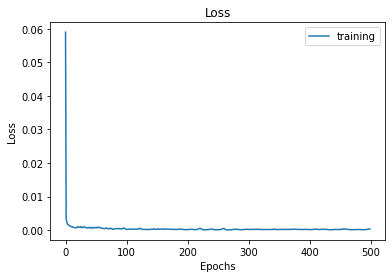

In [ ]:
plt.plot(train_loss, label='training')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'metric')

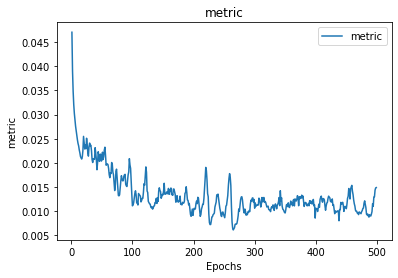

In [ ]:
plt.plot(metric, label='metric')
plt.legend()
plt.title('metric')
plt.xlabel('Epochs')
plt.ylabel('metric')

In [ ]:
np.set_printoptions(threshold=np.inf)
# Disable grad
with torch.no_grad():

    model.eval()
  
    """# Retrieve test value
    id = np.random.randint(0,len(test_dataset_Eform))
    test_value = test_dataset_Eform[id]
    image = test_value[0]
    target = test_value[1]


    # Generate a single prediction
    prediction = model(image.unsqueeze(0).float())
    
    print(target)
    print(prediction)"""


    # Generate predictions over the whole test dataset
    predictions = []
    targets     = []
    matrix      = [[0 for i in range(2)] for j in range(len(test_dataset_Eform))]
    count       = 0

    for i in range(len(test_dataset_Eform)):
        predictions.append(format(model(test_dataset_Eform[i][0].unsqueeze(0).float()).item(),'.4f'))
        targets.append(test_dataset_Eform[i][1].item())
        matrix[i][0] = float(predictions[i])
        matrix[i][1] = targets[i]
        if (abs(matrix[i][0]-matrix[i][1])<0.065):
          count +=1
        
    print('Prediction / Target')
    print(np.matrix(matrix))
    print('')


    print('accuracy is')
    print(100*count/len(test_dataset_Egap), '%')

Prediction / Target
[[2.257e-01 2.284e-01]
 [7.150e-02 5.910e-02]
 [1.609e-01 1.763e-01]
 [3.790e-02 3.890e-02]
 [1.444e-01 1.470e-01]
 [7.550e-02 4.230e-02]
 [6.990e-02 6.890e-02]
 [1.649e-01 1.371e-01]
 [1.023e-01 7.300e-02]
 [2.574e-01 2.529e-01]
 [1.736e-01 2.144e-01]
 [1.048e-01 1.214e-01]
 [2.962e-01 3.244e-01]
 [9.520e-02 9.030e-02]
 [8.420e-02 6.240e-02]
 [2.131e-01 2.129e-01]
 [1.957e-01 1.877e-01]
 [2.131e-01 2.170e-01]
 [3.926e-01 3.406e-01]
 [2.131e-01 2.267e-01]
 [9.660e-02 8.190e-02]
 [1.523e-01 1.436e-01]
 [1.521e-01 1.270e-01]
 [2.088e-01 2.016e-01]
 [7.960e-02 2.970e-02]
 [1.221e-01 1.281e-01]
 [2.740e-01 2.643e-01]
 [2.127e-01 2.350e-01]
 [1.297e-01 1.146e-01]
 [2.329e-01 2.301e-01]
 [2.607e-01 2.622e-01]
 [1.336e-01 1.363e-01]
 [1.201e-01 1.027e-01]
 [1.595e-01 1.599e-01]
 [6.540e-02 3.900e-02]
 [2.130e-01 2.113e-01]
 [1.702e-01 1.702e-01]
 [1.581e-01 1.592e-01]
 [2.397e-01 2.275e-01]
 [1.095e-01 1.005e-01]
 [7.100e-02 6.850e-02]
 [1.895e-01 1.549e-01]
 [6.960e-02 5.

In [ ]:
    npPredictions = np.array(predictions)
    print('The 5 smallest Eform value are ',npPredictions[np.argpartition(npPredictions,5)[:5]])
    print('Their respective indexes are   ',np.argpartition(npPredictions,5)[:5])

The 5 smallest Eform value are  ['0.0158' '0.0231' '0.0235' '0.0235' '0.0241']
Their respective indexes are    [532 236 586 267 585]


Egap training

In [ ]:
#Use GPU if available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



n_epochs =500

datalader =  train_dataloader_gap #Specify which dataloader to use

model = mlpSOAP().to(device) # Here initialize your model

#If using pre-trained weigths, uncomment this line:

#model.load_state_dict(torch.load('model_weights.pth'))

optimizer = torch.optim.Adam(model.parameters(),lr = 5e-3) #Define your optimizer

criterion = nn.MSELoss() #Define you loss function



#Training Loop

train_loss = []

metric = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    epoch_loss = [0.0, 0.0]

    running_loss = [0.0, 0.0]

    for i, data in enumerate(datalader, 0):

        # get the inputs; data is a list of [inputs, labels]

        x, y = data

        x = x.float().to(device)

        y = y.unsqueeze(1).float().to(device)

        # zero the parameter gradients

        optimizer.zero_grad()



        # forward + backward + optimize

        y_hat = model(x)

        loss = criterion(y, y_hat)

        with torch.no_grad():
          rmsle = torch.sqrt(criterion(torch.log(y+1), torch.log(y_hat+1))) #You have to build this function

        loss.backward()

        optimizer.step()

        epoch_loss[0] += loss.item()

        epoch_loss[1] += rmsle

        # print statistics

        running_loss[0] += loss.item()

        running_loss[1] += rmsle



        if i % 50 == 49:    # print every 50 mini-batches

            print('[%d, %5d] loss: %.3f RMSLE: %.3f' %

                  (epoch + 1, i + 1, running_loss[0] / 50, running_loss[1] / 50 ))

            running_loss = [0.0, 0.0]

    train_loss.append(epoch_loss[0]/(i+1))

    metric.append(epoch_loss[1]/(i+1))

    

torch.save(model.state_dict(), 'model_weights.pth')

print('END')

Text(0, 0.5, 'Loss')

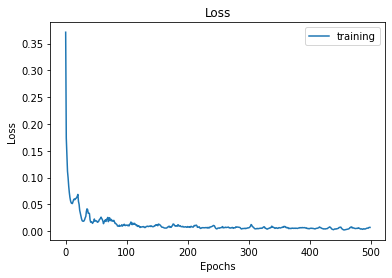

In [ ]:
plt.plot(train_loss, label='training')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'metric')

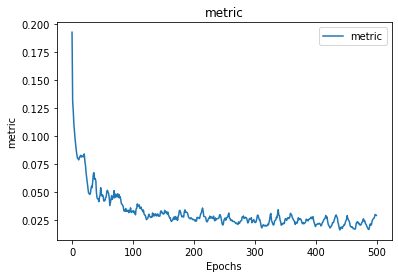

In [ ]:
plt.plot(metric, label='metric')
plt.legend()
plt.title('metric')
plt.xlabel('Epochs')
plt.ylabel('metric')

In [ ]:
np.set_printoptions(threshold=np.inf)
# Disable grad
with torch.no_grad():

    model.eval()
  
    """# Retrieve test value
    id = np.random.randint(0,len(test_dataset_Egap))
    test_value = test_dataset_Egap[id]
    image = test_value[0]
    target = test_value[1]


    # Generate a single prediction
    prediction = model(image.unsqueeze(0).float())
    
    print(target)
    print(prediction)"""


    # Generate predictions over the whole test dataset
    predictions = []
    targets     = []
    matrix      = [[0 for i in range(2)] for j in range(len(test_dataset_Egap))]
    count       = 0

    for i in range(len(test_dataset_Egap)):
        predictions.append(format(model(test_dataset_Egap[i][0].unsqueeze(0).float()).item(),'.4f'))
        targets.append(test_dataset_Egap[i][1].item())
        matrix[i][0] = float(predictions[i])
        matrix[i][1] = targets[i]
        if (abs(matrix[i][0]-matrix[i][1])<0.465):
          count +=1
        

    print('Prediction / Target')
    print(np.matrix(matrix))
    print('')


    print('accuracy is')
    print(100*count/len(test_dataset_Egap), '%')

Prediction / Target
[[1.5464 1.3584]
 [3.8673 3.8005]
 [3.4367 3.5526]
 [3.1803 3.0172]
 [1.7521 1.7354]
 [4.5864 4.8312]
 [3.3531 3.2741]
 [1.923  2.0217]
 [2.5637 2.7193]
 [3.0212 2.948 ]
 [1.9355 1.9344]
 [2.8371 2.7307]
 [0.9885 1.2681]
 [2.2941 2.2224]
 [0.9235 0.9531]
 [3.7731 3.7884]
 [1.7617 1.7039]
 [2.4017 2.3867]
 [1.1024 0.8884]
 [1.5251 1.3468]
 [1.809  1.8307]
 [2.9834 2.7216]
 [1.8031 1.8308]
 [3.1545 3.0846]
 [2.3508 2.4299]
 [0.9551 0.9409]
 [1.4868 1.3833]
 [1.8826 1.9285]
 [1.1235 1.177 ]
 [1.8872 1.9549]
 [1.0664 1.0742]
 [1.9174 1.9939]
 [1.5464 1.5379]
 [1.8518 1.8065]
 [0.8888 0.9095]
 [0.7702 0.8581]
 [3.6428 3.7204]
 [1.5464 1.4213]
 [1.8867 2.1532]
 [3.4    3.3906]
 [3.7513 3.7841]
 [3.1141 3.1232]
 [3.8545 3.889 ]
 [1.522  1.4478]
 [0.4977 0.6934]
 [3.8757 3.8615]
 [1.8662 1.966 ]
 [1.928  2.0158]
 [3.6386 3.6197]
 [1.1773 1.2128]
 [1.9848 1.9982]
 [1.7058 1.6872]
 [1.4586 1.3565]
 [2.7323 2.4624]
 [2.7148 2.8151]
 [0.4099 0.7562]
 [2.3429 2.3877]
 [3.0193 2.

In [ ]:
    npPredictions = np.array(predictions)
    print('Smallest gap values : ',npPredictions[np.argpartition(npPredictions,5)[:5]])
    print('Their indexes :',np.argpartition(npPredictions,5)[:5])

Smallest gap values :  ['0.1609' '0.1708' '0.1829' '0.1922' '0.2040']
Their indexes : [397 438 164 576 441]
